## Scope of Exercise 3

The goal of this project is to collect data about cities and countries, clean and merge the data to answer the following questions:

* How do the rankings change over time?
* How do these rankings correlate with each other for one specific year?
* How do they correlate with other statistics about the countries in which
  the cities are located?
* How do they correlate with quality of life rankings of the country
  in which the cities are located?
* What are the determining characteristics for livability of a city?
  How do they correlate with cost of living?

## How do the rankings change over time?
As a first step we look at the Numbeo Dataset and analyze the different indices visually over time

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
dfNumbeo = pd.read_csv(r"data/Numbeo.csv",sep=";",decimal=",")
dfNumbeo.columns = ['Period', 'City', 'QualityOfLife', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate']
dfNumbeo

,Period,City,QualityOfLife,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate
0,2020,"Caracas, Venezuela",0.00,2.36,15.10,39.28,27.68,150.55,34.69,72.41,99.93
1,2020,"Auckland, New Zealand",165.38,83.93,54.54,73.43,76.06,12.09,37.96,29.19,99.89
2,2020,"Guatemala City, Guatemala",107.71,40.18,37.39,63.63,44.26,9.89,50.11,69.66,99.89
3,2020,"Nairobi, Kenya",73.29,24.85,39.92,56.46,42.08,26.17,56.94,80.42,99.79
4,2020,"Medellin, Colombia",117.13,29.90,48.66,77.28,30.19,17.90,38.29,64.89,99.76
...,...,...,...,...,...,...,...,...,...,...,...
2304,2012-Q1,"Cairo, Egypt",-35.66,18.35,61.33,70.83,52.69,15.51,58.75,129.50,NaN
2305,2012-Q1,"Tehran, Iran",-50.44,47.52,43.27,43.40,60.86,13.72,73.50,140.75,NaN
2306,2012-Q1,"Moscow, Russia",-54.72,46.75,47.33,37.75,86.77,28.06,61.50,116.61,NaN
2307,2012-Q1,"Kolkata, India",-74.08,49.55,27.97,19.72,32.96,15.13,74.25,145.50,NaN


## What do these numbers mean? 
The Numbeos Quality of Life Ranking is a weighted index based on several key factors: 

### Purchasing Power
Relative to New York City: If domestic purchasing power is 40, this means that the inhabitants of that city with the average salary can afford to buy on an average 60% less goods and services than New York City residents with an average salary. 

### PropertyPriceToIncomeRatio
Generally calculated as the ratio of median apartment prices to median familial disposable income

### Cost of Living
These indices are relative to New York City (NYC). Which means that for New York City, each index should be 100(%). If another city has, for example, rent index of 120, it means that on an average in that city rents are 20% more expensive than in New York City.

### Pollution, Crime, Health Care
Is based on survey data of visitors. [-2, +2], with -2 having meaning of strongly negative and +2 meaning of strongly positive 

### Climate Index 
Is an estimation of the climate likability of a given city or a country. It is in the range [-100, +100] (higher is better)

### TrafficCommuteTime
Is a composite index of time consumed in traffic due to job commute, estimation of time consumption dissatisfaction, CO2 consumption estimation in traffic and overall inefficiencies in the traffic system

 protected void calculateIndex() {
    index = new TrafficIndex();
    index.time = overall.getTimeOverall();
    double tooMuchTime = 0.0;
    if (index.time > 25.0) {
      tooMuchTime = index.time - 25;
    }
    index.timeExp = index.time + Math.pow(tooMuchTime, Math.E);
    double co2 = 0.0;
    co2 += overall.time_bus * 20.0; // bus produces 20g of CO2 per minute (for each passenger)
    co2 += overall.time_driving * 133.0; // car produces 133g of CO2 per minute (assumes only driver)
    co2 += overall.time_train * 10.0; // train produces 10g of CO2 per minute (for each passenger)
    co2 += overall.time_tram * 15.0; // tram produces 15g of CO2 per minute (for each passenger)
    co2 += overall.time_other * 10.0; // other produces 10g of CO2 per minute
    co2 += overall.time_motorbike * 80.0; // motorbike produces 80g of CO2 per hour
    index.co2 = 2 * co2; 

    index.main = index.time + Math.sqrt(index.timeExp) + Math.sqrt(index.co2) + Math.sqrt(index.inefficiency);
}


### Quality of Life (QoL)
Not the raking is given by the following formular: 
QoL = Math.max(0, 100 + purchasingPowerInclRentIndex / 2.5 - (housePriceToIncomeRatio * 1.0) - costOfLivingIndex / 10 + safetyIndex / 2.0 + healthIndex / 2.5 - trafficTimeIndex / 2.0 - pollutionIndex * 2.0 / 3.0 + climateIndex / 3.0); 

The formular has changed over time. For example between June 2017 and Decembar 2017 they decreased the weight for the cost of living. 
This should be considered when drawing conclusions later! 
Further details can be found on this website: https://www.numbeo.com/quality-of-life/indices_explained.jsp



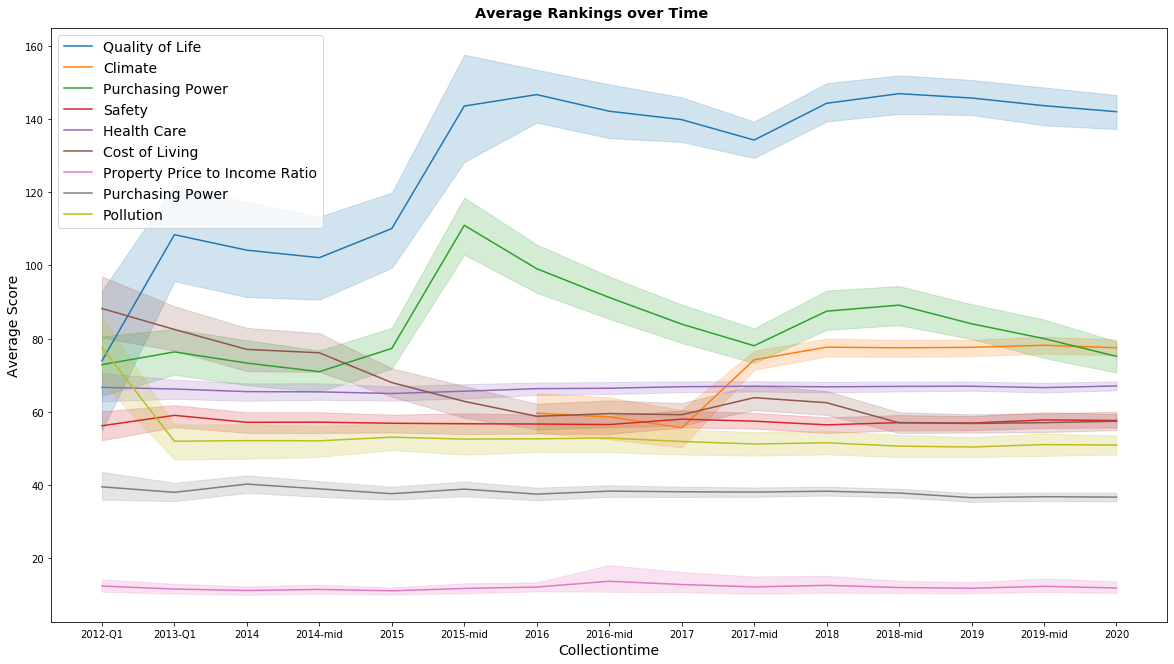

In [2]:
#How do the rankings change over time?

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))
fig.suptitle('Average Rankings over Time', fontsize='x-large', fontweight='bold')
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.95)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

sns.lineplot(x="Period", y="QualityOfLife", data=dfNumbeo,legend='brief',label='Quality of Life')
sns.lineplot(x="Period", y="Climate", data=dfNumbeo,legend='brief',label='Climate')
sns.lineplot(x="Period", y="PurchasingPower", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Safety", data=dfNumbeo,legend='brief',label='Safety')
sns.lineplot(x="Period", y="HealthCare", data=dfNumbeo,legend='brief',label='Health Care')
sns.lineplot(x="Period", y="CostOfLiving", data=dfNumbeo,legend='brief',label='Cost of Living')
sns.lineplot(x="Period", y="PropertyPriceToIncomeRatio", data=dfNumbeo,legend='brief',label='Property Price to Income Ratio')
sns.lineplot(x="Period", y="TrafficCommuteTime", data=dfNumbeo,legend='brief',label='Purchasing Power')
sns.lineplot(x="Period", y="Pollution", data=dfNumbeo,legend='brief',label='Pollution')

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('Collectiontime', fontsize=14)
plt.ylabel('Average Score', fontsize=14);
fig.savefig('visuals/RankingsOverTime.png')

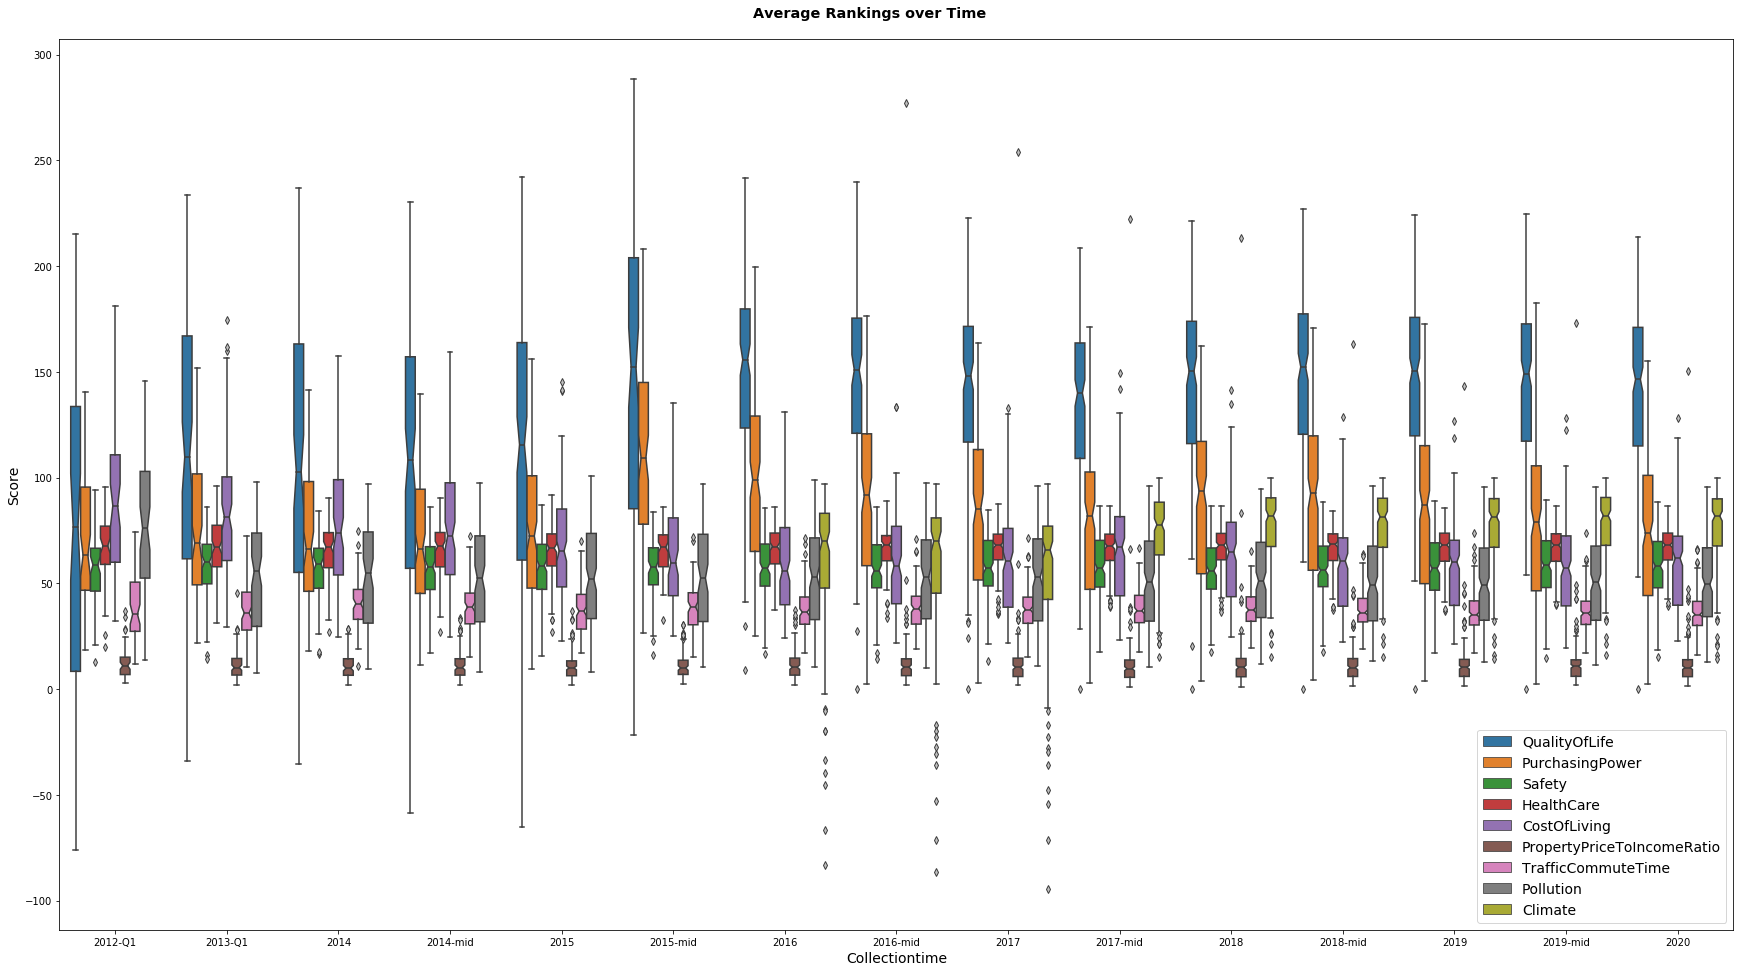

In [3]:
#There might be some outliers in the data so we decided to also look at a boxplot:
fig = plt.figure(figsize=(30,15))
fig.suptitle('Average Rankings over Time', fontsize='x-large', fontweight='bold')
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.95)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

dfNumbeoPivoted = pd.melt(dfNumbeo, col_level=0, id_vars=['Period', 'City'], value_vars=['QualityOfLife', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate'])


flierprops = dict(markerfacecolor='0.75', markersize=5,    linestyle='none')
g = sns.boxplot(x="Period", y="value",hue="variable",notch=True, data=dfNumbeoPivoted,order=np.flip(dfNumbeo.Period.unique()),flierprops=flierprops)

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('Collectiontime', fontsize=14)
plt.ylabel('Score', fontsize=14);
fig.savefig('visuals/RankingsOverTimeBoxPlot.png')

## Interpretation
The Quality of life rankings on average increased from 2012 to 2015. Then they decreased a bit till mid 2017 and recovered again to mid 2018. 
After that the quality of life ranking decreased again.


## How do city ratings correlate with quality of life rankings of the country in which the cities are located?


TODO: For this we should integrate the data about cities

## How do these rankings correlate with each other for one specific year?

In [4]:
dfNumbeo = pd.read_csv(r"data/Numbeo.csv",sep=";",decimal=",")
dfNumbeo.columns = ['Period', 'City', 'NumbeoIndex', 'PurchasingPower', 'Safety', 'HealthCare', 'CostOfLiving', 'PropertyPriceToIncomeRatio', 'TrafficCommuteTime','Pollution', 'Climate']

dfNumbeo[['City','Country','Country2']] = dfNumbeo['City'].str.split(',',expand=True)
#why does it introduce another column?
#dfNumbeo.to_csv("numbeoprocessed.csv", index=False)
#Answer United States is part of the city name, so dropping this column...
dfNumbeo.drop('Country2', axis=1, inplace=True)
dfNumbeo2012 = dfNumbeo.set_index('Period').loc['2012-Q1',:]
dfNumbeo2012.reset_index(inplace=True)
dfNumbeo2012['Country'] = dfNumbeo2012.Country.str.strip()
dfNumbeo2012.set_index('City',inplace=True)
# fix us of a cities/country
dfNumbeo2012.loc['San Francisco','Country'] = "United States"
dfNumbeo2012.loc['Los Angeles','Country'] = "United States"
dfNumbeo2012.loc['New York','Country'] = "United States"
dfNumbeo2012["NumbeoRank"] = dfNumbeo2012["NumbeoIndex"].rank(ascending=False) 
dfNumbeo2012


,Period,NumbeoIndex,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,Country,NumbeoRank
City,,,,,,,,,,,,
Berlin,2012-Q1,215.25,140.62,77.34,64.81,89.06,5.74,23.00,40.00,NaN,Germany,1.0
Zurich,2012-Q1,213.18,136.31,83.85,77.78,166.07,8.27,27.33,26.50,NaN,Switzerland,2.0
Edmonton,2012-Q1,204.86,124.69,58.98,78.89,112.10,3.59,35.33,21.25,NaN,Canada,3.0
Perth,2012-Q1,196.00,118.34,48.75,87.04,142.18,5.24,27.00,15.00,NaN,Australia,4.0
Calgary,2012-Q1,190.78,124.25,71.88,70.42,111.71,4.58,62.00,25.08,NaN,Canada,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Cairo,2012-Q1,-35.66,18.35,61.33,70.83,52.69,15.51,58.75,129.50,NaN,Egypt,57.0
Tehran,2012-Q1,-50.44,47.52,43.27,43.40,60.86,13.72,73.50,140.75,NaN,Iran,58.0
Moscow,2012-Q1,-54.72,46.75,47.33,37.75,86.77,28.06,61.50,116.61,NaN,Russia,59.0


In [5]:
##loading mercer data extracted from https://en.wikipedia.org/wiki/Mercer_Quality_of_Living_Survey
dfMercer = pd.read_csv('data/Mercer.csv')
dfMercer.columns = ['City','Country','MercerIndex','Year','MercerRank']
dfMercer2012 = dfMercer.loc[dfMercer['Year']== 2012,:]
dfMercer2012.set_index('City',inplace=True)

In [6]:
mergedDf = dfMercer2012.merge(dfNumbeo2012, left_index=True, right_index=True)

#now that we operate on a subset of the data we should rerank the cities to have comparable ranks! 
#otherwise we would have higher ranks for numbeo cities because we have more data there and our goal is to see if numbeo would sort the cities in the same order as mercer does. 
mergedDf["NumbeoReRank"] = mergedDf["NumbeoRank"].rank(ascending=False) 
mergedDf["MercerReRank"] = mergedDf["MercerRank"].rank(ascending=False) 
mergedDf.to_csv("data/NumbeoAndMercer.csv", index=False)
mergedDf

,Country_x,MercerIndex,Year,MercerRank,Period,NumbeoIndex,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,Country_y,NumbeoRank,NumbeoReRank,MercerReRank
City,,,,,,,,,,,,,,,,,,
Vancouver,Canada,107.4,2012,5,2012-Q1,133.65,95.55,61.65,84.72,110.81,10.42,40.00,52.50,NaN,Canada,16.0,9.0,20.0
Copenhagen,Denmark,106.2,2012,9,2012-Q1,155.40,95.37,54.69,89.81,129.34,6.26,36.67,34.17,NaN,Denmark,12.0,13.0,19.0
Sydney,Australia,106.3,2012,10,2012-Q1,165.67,100.96,72.80,78.33,139.12,8.63,46.70,25.62,NaN,Australia,8.0,16.0,18.0
Berlin,Germany,105.0,2012,16,2012-Q1,215.25,140.62,77.34,64.81,89.06,5.74,23.00,40.00,NaN,Germany,1.0,20.0,16.0
Toronto,Canada,105.3,2012,15,2012-Q1,159.07,105.78,68.23,70.56,106.58,7.65,38.09,42.50,NaN,Canada,11.0,14.0,17.0
Melbourne,Australia,104.8,2012,17,2012-Q1,107.12,97.41,45.98,72.22,125.54,10.49,31.56,64.03,NaN,Australia,22.0,7.0,15.0
Perth,Australia,104.2,2012,21,2012-Q1,196.00,118.34,48.75,87.04,142.18,5.24,27.00,15.00,NaN,Australia,4.0,19.0,13.0
Montreal,Canada,104.2,2012,23,2012-Q1,164.99,114.23,70.88,70.50,99.58,3.95,32.17,58.75,NaN,Canada,9.0,15.0,11.0
Stockholm,Sweden,104.5,2012,19,2012-Q1,166.05,84.85,73.44,85.65,118.21,11.36,30.67,20.00,NaN,Sweden,7.0,17.0,14.0


<Figure size 936x936 with 0 Axes>

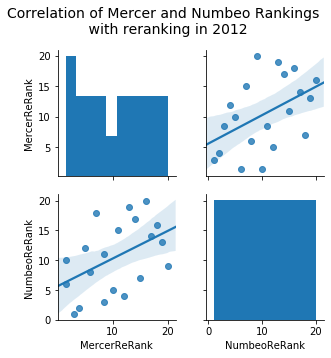

In [7]:
fig = plt.figure(figsize=(13,13))
g = sns.pairplot(mergedDf.loc[:,['MercerReRank','NumbeoReRank']],kind="reg")
g.fig.suptitle("Correlation of Mercer and Numbeo Rankings \n with reranking in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
g.fig.savefig('visuals/CorrelationOfMercerAndNumbeoRanking2012withreranking.png')



<Figure size 720x720 with 0 Axes>

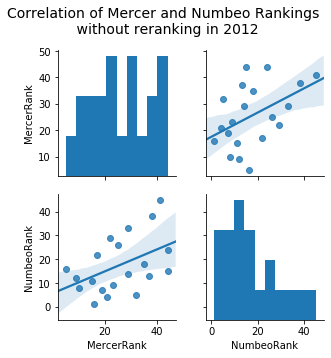

In [8]:
fig = plt.figure(figsize=(10,10))
g = sns.pairplot(mergedDf.loc[:,['MercerRank','NumbeoRank']],kind="reg")
g.fig.suptitle("Correlation of Mercer and Numbeo Rankings \n without reranking in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.85,left=0.2,bottom=0.1)
g.fig.savefig('visuals/CorrelationOfMercerAndNumbeoRanking2012withoutreranking.png')



In [9]:
%load_ext rpy2.ipython

In [10]:
%%R -o output
d <- read.csv2("data/NumbeoAndMercer.csv",sep=',',dec ='.')
rankcorrelation <- cor(d$NumbeoReRank, d$MercerReRank,  method = "spearman", use = "complete.obs")
indexcorrelation <- cor(d$NumbeoIndex, d$MercerIndex,  method = "spearman", use = "complete.obs")
output <- capture.output({c(rankcorrelation,indexcorrelation) })

In [11]:
print(output)

[1] "[1] 0.4650114 0.4386758"



## Insight
Interesting to see that Mercer Rankings correlate with Numbeo Rankings. Especially because Mercers sells the ranking data for 20k and Numbeo is (almost) for free. 

In [12]:

#Source: United Nations Human Settlements Programme (UN-Habitat), Global Urban Indicators Database 2012.
dfProsperity2012 = pd.read_csv('data/city-prosperity-index_country.csv')
dfProsperity2012.columns = ['Country','City','Cpi5','Cpi4','Productivity','QoLUN','Infrastructure','Environment','Equity']

dfProsperity2012 = dfProsperity2012.set_index('City')

dfProsperity2012["UNRank"] = dfProsperity2012["QoLUN"].rank(ascending=False) 

mergedDf = mergedDf.merge(dfProsperity2012, left_index=True, right_index=True) 
mergedDf["UNReRank"] = mergedDf["UNRank"].rank(ascending=False) 
mergedDf

,Country_x,MercerIndex,Year,MercerRank,Period,NumbeoIndex,PurchasingPower,Safety,HealthCare,CostOfLiving,...,Country,Cpi5,Cpi4,Productivity,QoLUN,Infrastructure,Environment,Equity,UNRank,UNReRank
City,,,,,,,,,,,,,,,,,,,,,
Copenhagen,Denmark,106.2,2012,9,2012-Q1,155.40,95.37,54.69,89.81,129.34,...,Denmark,0.913,0.911,0.855,0.871,0.997,0.928,0.922,16.0,4.0
Toronto,Canada,105.3,2012,15,2012-Q1,159.07,105.78,68.23,70.56,106.58,...,Canada,0.890,0.934,0.874,0.907,0.997,0.963,0.733,6.0,8.0
Melbourne,Australia,104.8,2012,17,2012-Q1,107.12,97.41,45.98,72.22,125.54,...,Australia,0.903,0.925,0.867,0.875,0.996,0.967,0.820,14.0,5.0
Stockholm,Sweden,104.5,2012,19,2012-Q1,166.05,84.85,73.44,85.65,118.21,...,Sweden,0.898,0.934,0.896,0.925,0.995,0.921,0.767,2.5,9.5
Brussels,Belgium,105.4,2012,22,2012-Q1,83.68,81.03,42.97,84.03,114.64,...,Belgium,0.883,0.910,0.862,0.864,0.997,0.922,0.783,21.5,1.0
Dublin,Ireland,103.6,2012,35,2012-Q1,117.57,88.79,44.09,25.46,124.54,...,Ireland,0.913,0.929,0.901,0.867,0.996,0.958,0.850,18.0,2.5
Lisbon,Portugal,100.3,2012,44,2012-Q1,102.92,63.25,58.35,66.27,78.69,...,Portugal,0.853,0.899,0.827,0.867,0.995,0.916,0.692,18.0,2.5
Paris,France,102.9,2012,29,2012-Q1,72.12,80.08,52.39,72.92,119.69,...,France,0.897,0.927,0.895,0.925,0.996,0.895,0.788,2.5,9.5
London,United Kingdom,101.6,2012,38,2012-Q1,45.74,87.96,40.13,67.78,126.08,...,United Kingdom,0.904,0.934,0.923,0.898,0.997,0.920,0.793,9.0,7.0


<Figure size 720x720 with 0 Axes>

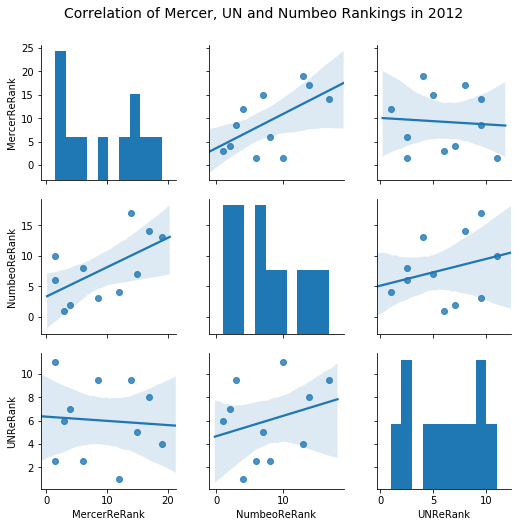

In [13]:
fig = plt.figure(figsize=(10,10))
g = sns.pairplot(mergedDf.loc[:,['MercerReRank','NumbeoReRank','UNReRank']],kind="reg")
g.fig.suptitle("Correlation of Mercer, UN and Numbeo Rankings in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig('visuals/CorrelationOfMercerAndUNAndNumbeoRanking2012.png')


In [14]:
#Todo merging only Numbeo with UN Data! (Removing the bottleneck Mercer)
mergedDf = dfProsperity2012.merge(dfNumbeo2012, left_index=True, right_index=True)
mergedDf["NumbeoReRank"] = mergedDf["NumbeoRank"].rank(ascending=False) 
mergedDf["UNReRank"] = mergedDf["UNRank"].rank(ascending=False) 
mergedDf

,Country_x,Cpi5,Cpi4,Productivity,QoLUN,Infrastructure,Environment,Equity,UNRank,Period,...,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,Country_y,NumbeoRank,NumbeoReRank,UNReRank
City,,,,,,,,,,,,,,,,,,,,,
Melbourne,Australia,0.903,0.925,0.867,0.875,0.996,0.967,0.820,14.0,2012-Q1,...,72.22,125.54,10.49,31.56,64.03,NaN,Australia,22.0,17.0,17.0
Brussels,Belgium,0.883,0.910,0.862,0.864,0.997,0.922,0.783,21.5,2012-Q1,...,84.03,114.64,6.33,22.00,90.00,NaN,Belgium,29.0,14.0,10.5
Toronto,Canada,0.890,0.934,0.874,0.907,0.997,0.963,0.733,6.0,2012-Q1,...,70.56,106.58,7.65,38.09,42.50,NaN,Canada,11.0,22.0,21.0
Shanghai,China,0.826,0.832,0.671,0.836,0.900,0.950,0.800,26.5,2012-Q1,...,34.72,58.29,37.05,31.20,140.25,NaN,China,61.0,1.0,8.0
Prague,Czech Republic,0.871,0.882,0.855,0.771,0.992,0.926,0.827,34.0,2012-Q1,...,63.24,68.66,14.11,29.00,59.00,NaN,Czech Republic,28.0,15.0,6.0
Copenhagen,Denmark,0.913,0.911,0.855,0.871,0.997,0.928,0.922,16.0,2012-Q1,...,89.81,129.34,6.26,36.67,34.17,NaN,Denmark,12.0,21.0,16.0
Cairo,Egypt,0.722,0.730,0.679,0.743,0.916,0.616,0.692,40.0,2012-Q1,...,70.83,52.69,15.51,58.75,129.50,NaN,Egypt,57.0,3.0,2.0
Paris,France,0.897,0.927,0.895,0.925,0.996,0.895,0.788,2.5,2012-Q1,...,72.92,119.69,17.10,32.80,74.17,NaN,France,33.0,12.0,22.5
Athens,Greece,0.862,0.889,0.800,0.885,0.996,0.884,0.762,12.0,2012-Q1,...,51.69,101.53,11.01,38.67,140.00,NaN,Greece,56.0,4.0,18.0


<Figure size 720x720 with 0 Axes>

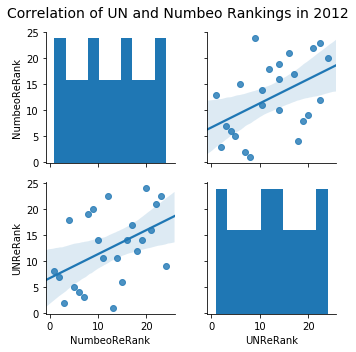

In [15]:
fig = plt.figure(figsize=(10,10))

g = sns.pairplot(mergedDf.loc[:,['NumbeoReRank','UNReRank']],kind="reg")
g.fig.suptitle("Correlation of UN and Numbeo Rankings in 2012", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.9)
g.fig.savefig('visuals/CorrelationOfUNAndNumbeoRanking2012.png')

## How do they correlate with other statistics about the countries in which the cities are located? 
TODO: For this we should integrate the data about cities

## What are the determining characteristics for livability of a city? How do they correlate with cost of living?

<Figure size 2160x1080 with 0 Axes>

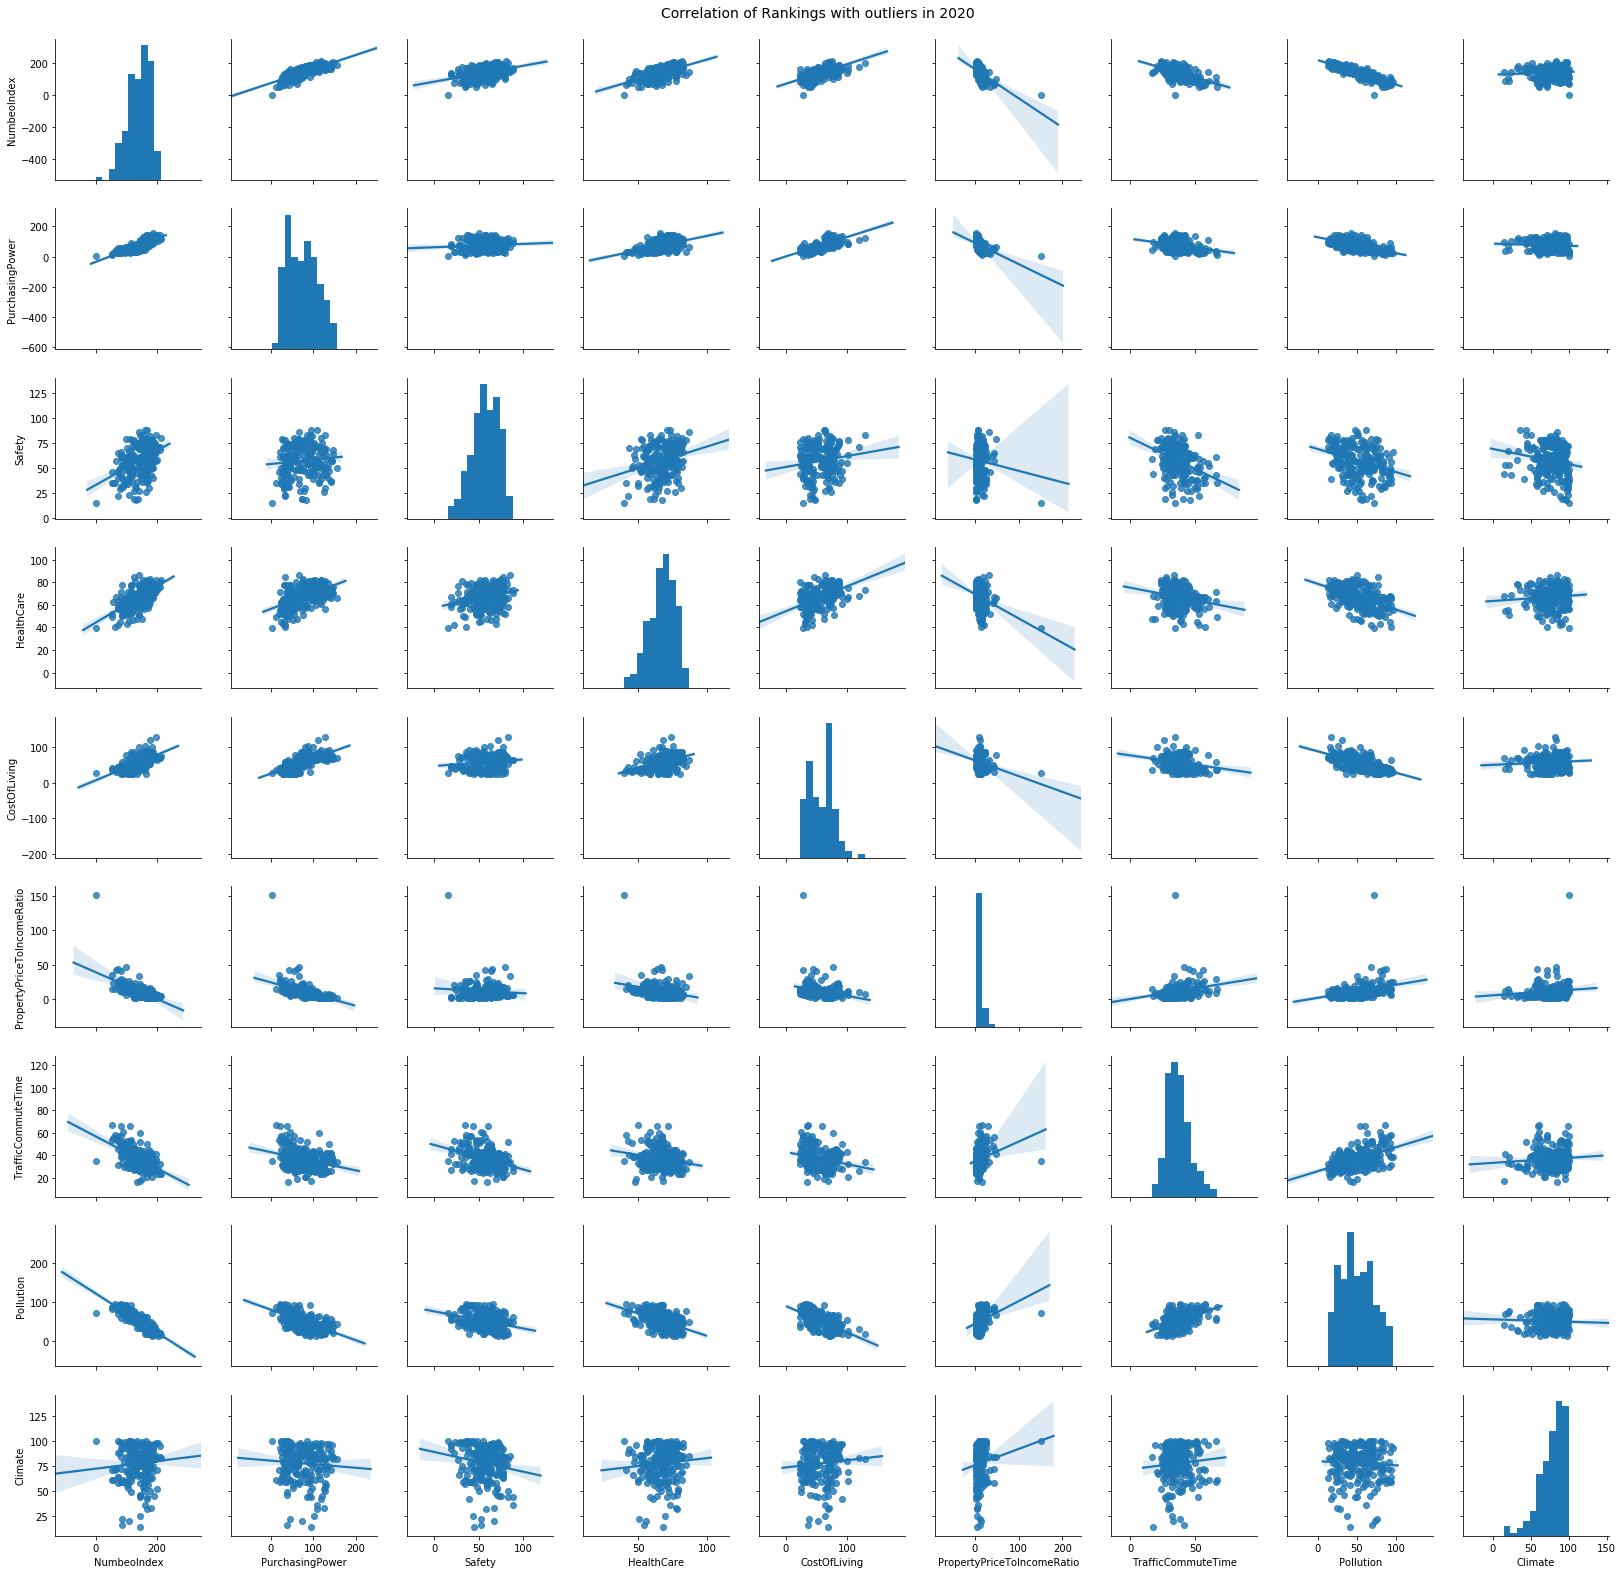

In [16]:
#for this question we will look at the most recent Numbeo data (2020) and make a visual analysis. 
#after that we will train a linear regression model in r and interpret the inference statistics

dfNumbeo2020 = dfNumbeo.set_index('Period').loc['2020',:]
#dfNumbeo2020


#There might be some outliers in the data so we decided to also look at a boxplot:
#fig = plt.figure(figsize=(12,10))
#fig.suptitle('Correlation of City Characteristics', fontsize='x-large', fontweight='bold', y=0.93)
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.


fig = plt.figure(figsize=(30,15))
#fig.suptitle('Correlation of Rankings in 2020', fontsize='x-large', fontweight='bold')
#fig.subplots_adjust(top=0.88,left=0.2,bottom=0.3)

#ax = fig.add_subplot(111)
g = sns.pairplot(dfNumbeo2020,kind="reg")
g.fig.subplots_adjust(top=0.95)
g.fig.suptitle("Correlation of Rankings with outliers in 2020", y=0.97,fontsize=14)

# plt.title('Correlation of Rankings in 2020', fontdict=fontdict, color="black", position=(0.5,1));

g.fig.savefig('visuals/CorrelationOfRankingsIn2020WithOutliers.png')


In [17]:
#find the outliers
#taken from https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance
def MahalanobisDist(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            vars_mean = []
            for i in range(data.shape[0]):
                vars_mean.append(list(data.mean(axis=0)))
            diff = data - vars_mean
            md = []
            for i in range(len(diff)):
                md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

            if verbose:
                print("Covariance Matrix:\n {}\n".format(covariance_matrix))
                print("Inverse of Covariance Matrix:\n {}\n".format(inv_covariance_matrix))
                print("Variables Mean Vector:\n {}\n".format(vars_mean))
                print("Variables - Variables Mean Vector:\n {}\n".format(diff))
                print("Mahalanobis Distance:\n {}\n".format(md))
            return md
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(data, verbose)
    # one popular way to specify the threshold
    #m = np.mean(MD)
    #t = 3. * m if extreme else 2. * m
    #outliers = []
    #for i in range(len(MD)):
    #    if MD[i] > t:
    #        outliers.append(i)  # index of the outlier
    #return np.array(outliers)

    # or according to the 68–95–99.7 rule
    std = np.std(MD)
    k = 3. * std if extreme else 2. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)


def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False


def handle_outliers(noisy_data):
    """ 
    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    cleaned_data: data frame with outliers
    """
    df = noisy_data 
    #using a multivariate outlier detection based on mahalanobis distance from 
    #https://stackoverflow.com/questions/46827580/multivariate-outlier-removal-with-mahalanobis-distance
    outliers_indices = MD_detectOutliers(df.iloc[:,2:10].values, verbose=False)

    print("Outliers Indices: {}\n".format(outliers_indices))
    df = df.reset_index()
    inliers = pd.Int64Index(np.arange(len(df))).difference(outliers_indices)
    cleaned_data = df.iloc[inliers]
    return cleaned_data
    
dfNumbeo2020_cleaned = handle_outliers(dfNumbeo2020).set_index('Period')


Outliers Indices: [  0 226]



In [18]:
#looking at the outliers:
dfNumbeo2020.iloc[[0,226],:]

,City,NumbeoIndex,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,Country
Period,,,,,,,,,,,
2020,Caracas,0.00,2.36,15.10,39.28,27.68,150.55,34.69,72.41,99.93,Venezuela
2020,Regina,144.46,95.08,44.51,68.15,68.19,4.97,17.17,41.21,14.28,Canada


<Figure size 2160x1080 with 0 Axes>

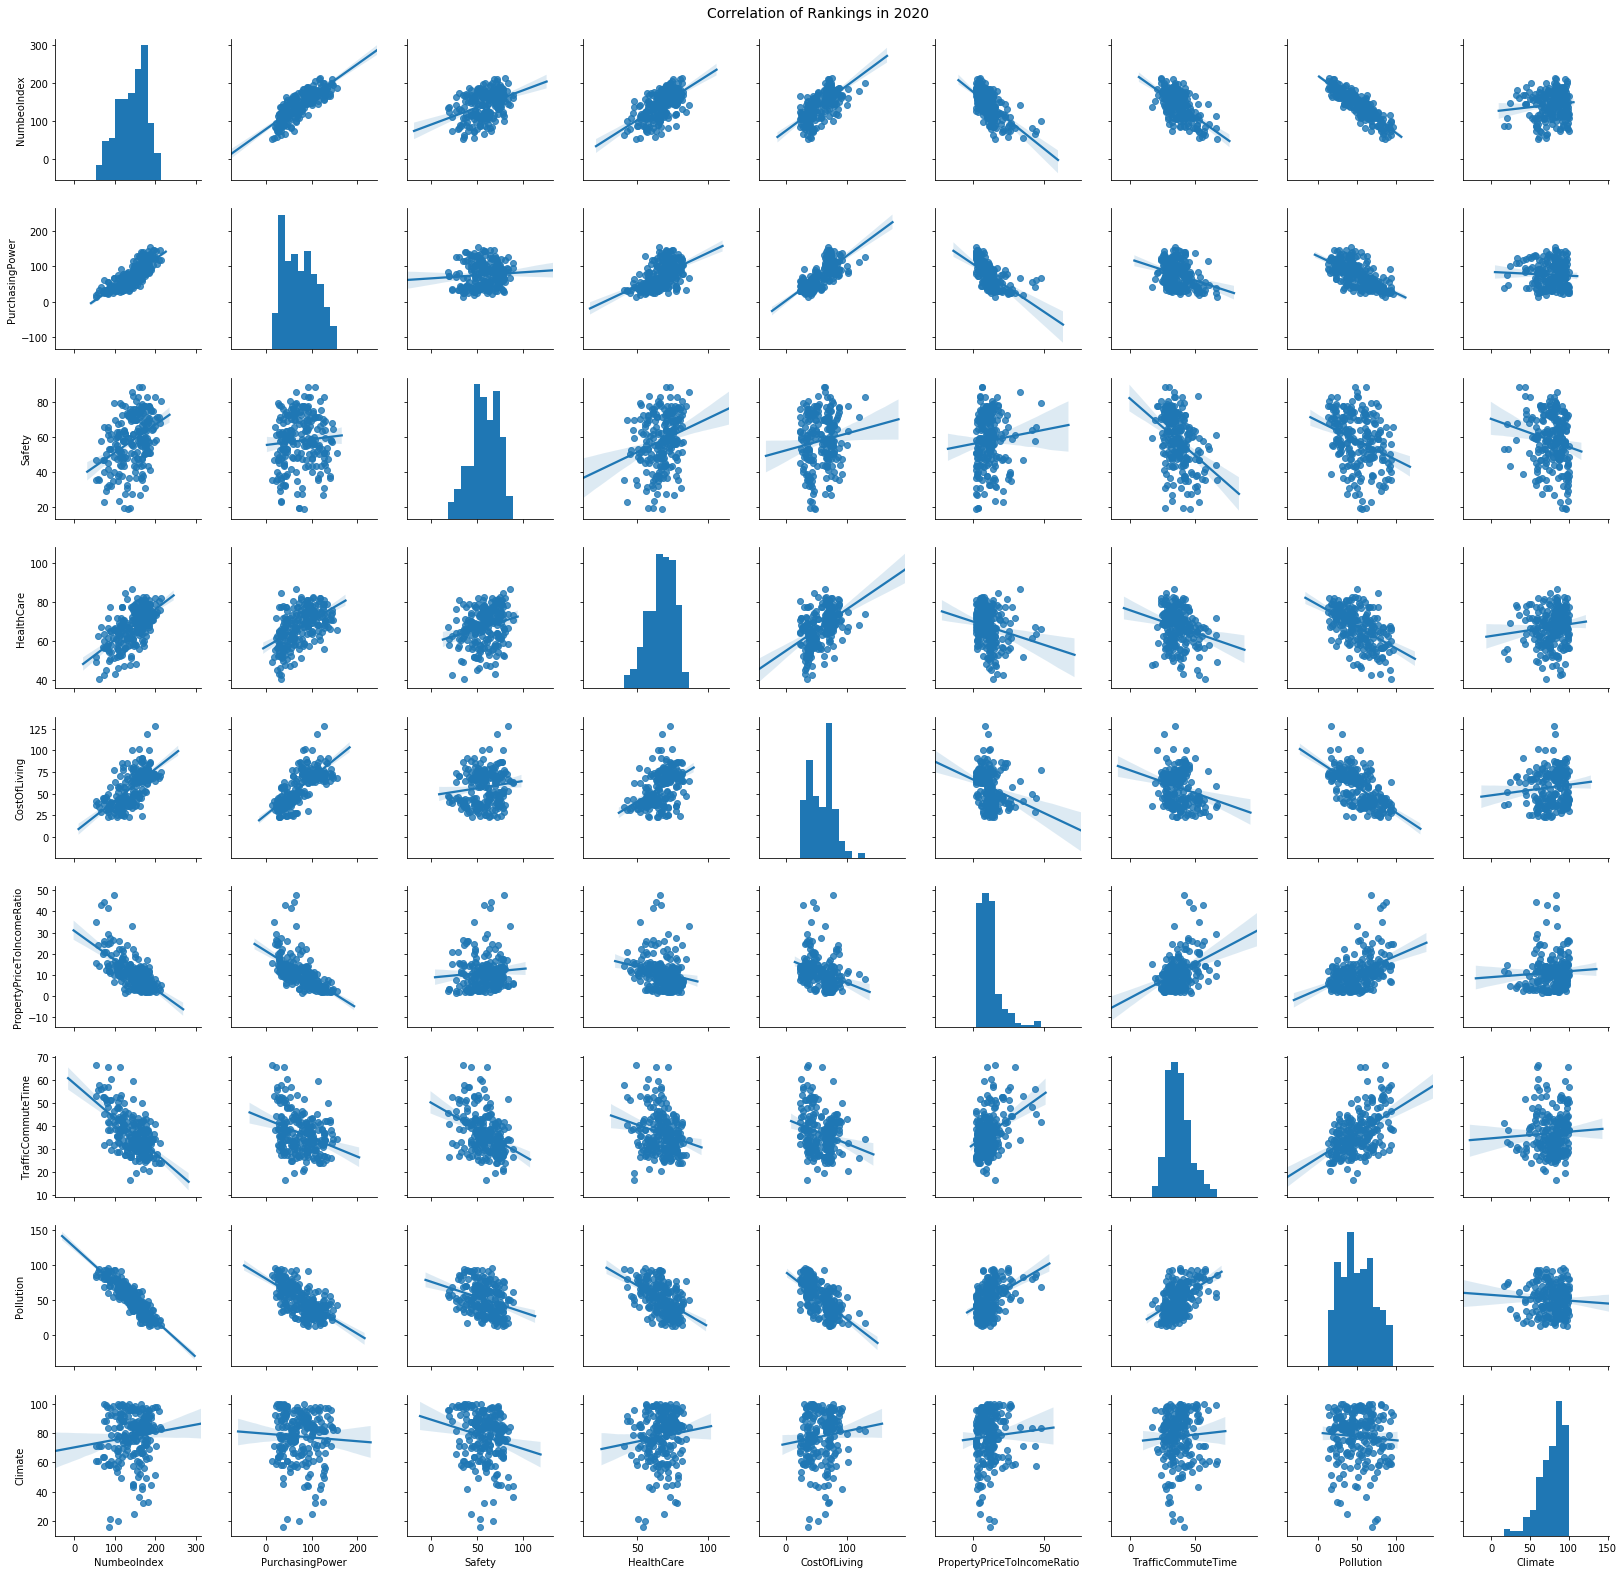

In [19]:
#plotting again without outliers
#dfNumbeo2020_cleaned

fig = plt.figure(figsize=(30,15))
#fig.suptitle('Correlation of Rankings in 2020', fontsize='x-large', fontweight='bold')

#ax = fig.add_subplot(111)
g = sns.pairplot(dfNumbeo2020_cleaned,kind="reg")
g.fig.suptitle("Correlation of Rankings in 2020", y=0.97,fontsize=14)
g.fig.subplots_adjust(top=0.95)

# plt.title('Correlation of Rankings in 2020', fontdict=fontdict, color="black", position=(0.5,1));

g.fig.savefig('visuals/CorrelationOfRankingsIn2020.png')


No handles with labels found to put in legend.


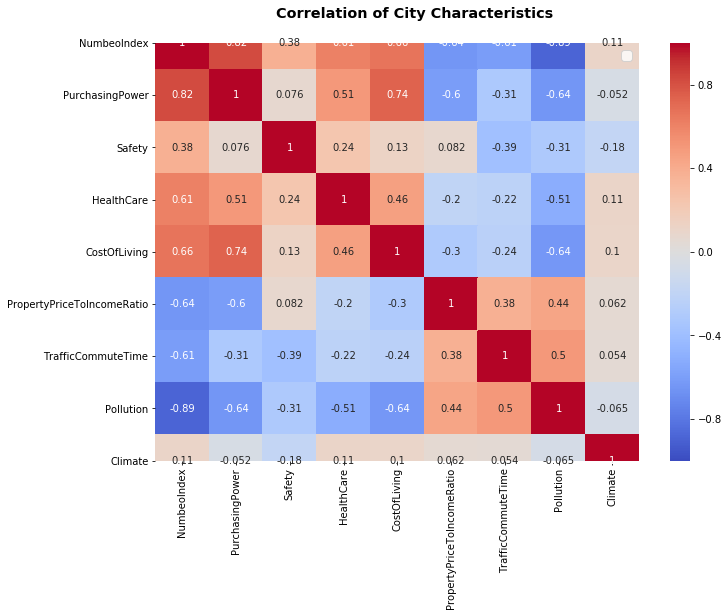

In [20]:
#There might be some outliers in the data so we decided to also look at a boxplot:
fig = plt.figure(figsize=(12,10))
fig.suptitle('Correlation of City Characteristics', fontsize='x-large', fontweight='bold', y=0.93)
#This is used for the main title. 'figure()' is a class that provides all the plotting elements of a diagram. 
#This must be used first or else the title will not show.fig.subplots_adjust(top=0.85) solves our overlapping title problem.
fig.subplots_adjust(top=0.88,left=0.2,bottom=0.3)


ax = fig.add_subplot(111)

fontdict={'fontsize': 14, 'fontweight' : 'book',    'verticalalignment': 'baseline',   'horizontalalignment': 'center'}

#ax.set_title('Plotting Tutorial', fontdict=fontdict)

g = sns.heatmap(dfNumbeo2020_cleaned.corr(),  vmin=-1, cmap='coolwarm', annot=True);

plt.legend(fontsize=14)
#plt.title('Average Rankings over Time', fontdict=fontdict, color="black", position=(0.5,1));
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14);
fig.savefig('visuals/CorrelationOfCityCharacteristics.png')

In [21]:
#g = sns.boxplot(x="Period", y="value",hue="variable", data=dfNumbeoPivoted,order=np.flip(dfNumbeo.Period.unique()))
#dir(g)

In [22]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
%%R -o output
d <- read.csv2("data/Numbeo.csv",sep=';',dec =',')
n <- nrow(d)
set.seed(123)
train <- sample(1:n,round(n*2/3))

res <- lm(Cost.of.Living.Index~Purchasing.Power.Index+Safety.Index+Health.Care.Index+Property.Price.to.Income.Ratio+Traffic.Commute.Time.Index+Pollution.Index+Climate.Index,data=d[train,])
summary(res)
output <- capture.output({summary(res) })


In [24]:
print(output)

 [1] ""                                                                        
 [2] "Call:"                                                                   
 [3] "lm(formula = Cost.of.Living.Index ~ Purchasing.Power.Index + "           
 [4] "    Safety.Index + Health.Care.Index + Property.Price.to.Income.Ratio + "
 [5] "    Traffic.Commute.Time.Index + Pollution.Index + Climate.Index, "      
 [6] "    data = d[train, ])"                                                  
 [7] ""                                                                        
 [8] "Residuals:"                                                              
 [9] "    Min      1Q  Median      3Q     Max "                                
[10] "-46.124  -9.026  -1.616   7.759  68.606 "                                
[11] ""                                                                        
[12] "Coefficients:"                                                           
[13] "                               Est

## Interpretation

From the visual analysis we see that there is a strong postive correlation of the cost of living and the quality of life, purchasing power and safety.

The higher the cost of living the lower is the ratio between the property prices and the income. Also the cost of living is lower when the commute time index or the pollution is high.
In addition when the climate is nice the cost of living tends to be higher. This is also confirmed by the inference statistics of the simple regression model. 

The model shows coefficients significant from 0 for all indices. 


And interesting insight is that in order to get good health care you not necessarly have to have high cost of living.


## Are there cities with a higher healthcare ranking and lower cost of living as Vienna?


In [25]:
ViennaHealthCare = dfNumbeo2020_cleaned.loc[dfNumbeo2020_cleaned.City == 'Vienna','HealthCare'].values[0]
ViennaCostOfLiving = dfNumbeo2020_cleaned.loc[dfNumbeo2020_cleaned.City == 'Vienna','CostOfLiving'].values[0]

dfNumbeo2020_cleaned.loc[((dfNumbeo2020_cleaned.HealthCare >= ViennaHealthCare) & (dfNumbeo2020_cleaned.CostOfLiving <= ViennaCostOfLiving)) ,:]


,City,NumbeoIndex,PurchasingPower,Safety,HealthCare,CostOfLiving,PropertyPriceToIncomeRatio,TrafficCommuteTime,Pollution,Climate,Country
Period,,,,,,,,,,,
2020,Valencia,176.93,76.62,74.86,82.60,51.95,7.48,27.24,43.75,93.84,Spain
2020,Madrid,152.58,73.65,69.76,79.27,58.25,12.98,35.29,53.25,85.47,Spain
2020,Leeds,169.51,102.24,57.03,82.20,64.83,6.46,32.61,47.60,84.59,United Kingdom
2020,Taipei,143.04,67.10,85.80,86.58,64.30,33.10,33.56,49.71,84.38,Taiwan
2020,Vienna,184.49,83.16,76.99,78.78,65.64,13.90,26.55,18.44,81.77,Austria
2020,Chiang Mai,124.09,33.90,77.76,84.45,46.64,17.68,27.40,77.09,75.93,Thailand
2020,Mangalore,166.08,58.91,75.86,80.14,23.49,7.44,32.14,35.75,66.65,India
2020,Hamilton,155.59,103.16,51.19,81.92,64.24,6.30,34.56,51.58,61.06,Canada
2020,Madison,200.18,124.31,70.27,78.83,64.67,3.35,23.73,17.61,51.64,WI


## Answer
Taipei ranks highest in terms of health care with similar cost of living, but the purchasing power in vienna is higher the pollution is lower and the time to commute is lower well. Thats why vienna scores higher! 